IMPORT the libraries

In [125]:
import torch
from google.colab import files
# install the latest release of PyTorch3D
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.13.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'


# add path for demo utils functions 
import sys
import os


import tqdm
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    SoftSilhouetteShader,
    TexturesVertex
)

!pip install trimesh # install trimesh
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(1234)


!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid


from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)
import pytorch3d
import torch
from pytorch3d.renderer import (
    AlphaCompositor,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    HardPhongShader,
)
from pytorch3d.io import load_obj
from tqdm import tqdm
from PIL import Image, ImageDraw
from pytorch3d.io import IO

# Setup cuda
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-02-06 11:07:48--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.2’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-02-06 11:07:48 (30.6 MB/s) - ‘plot_image_grid.py.2’ saved [1608/1608]



***EXTRACT THE POINT CLOUD FROM FILE OBJECT***

In [ ]:
# FILL WITH THE CODE IN THE JUPYTER

In [ ]:
# Data dir
DATA_DIR = "./"
obj_filename = os.path.join(DATA_DIR, "sandal.pt")


# Load the point cloud
pointcloud = torch.load(obj_filename)
verts = pointcloud[0]  
rgb=torch.randn((pointcloud.shape))[0]
print('verts shape: ',verts.shape,'rgb shape: ',rgb.shape)
point_cloud = Pointclouds(points=[verts], features=[rgb])

verts shape:  torch.Size([4096, 3]) rgb shape:  torch.Size([4096, 3])


In [ ]:
plot_scene({
    "Pointcloud": {
        "person": point_cloud
    }
})

***EXTRACT THE POINCLOUD FROM MESH***

In [5]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473402300/473402300 [==============================] - 37s 0us/step


In [63]:
# plot the mesh of a sample
mesh = trimesh.load(os.path.join(DATA_DIR, 'table/train/table_0028.off'))
mesh.show()

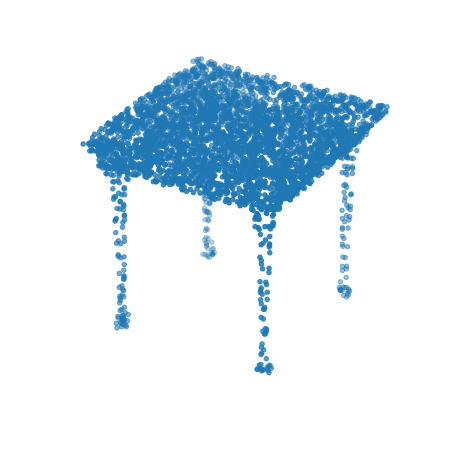

In [43]:
# sampled point cloud
points = mesh.sample(4096)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [78]:
# parse the entire dataset
def parse_dataset(num_points=4096):

    points = []
    labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        
        print("processing class: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]
        train_files = glob.glob(os.path.join(folder, "train/*0028.off"))
        test_files = glob.glob(os.path.join(folder, "test/*0028.off"))
        
        files = sorted(test_files+train_files)
        for f in files:
            points.append(trimesh.load(f).sample(num_points))
            labels.append(i)
        

    return (
        np.array(points),
        np.array(labels),
        class_map,
    )

In [79]:
NUM_POINTS = 4096
NUM_CLASSES = 10

points, labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: desk
processing class: bed
processing class: monitor
processing class: bathtub
processing class: chair
processing class: night_stand
processing class: table
processing class: toilet
processing class: sofa
processing class: dresser


In [81]:
torch.save(points, 'points.pt')
torch.save(labels, 'labels.pt')
torch.save(CLASS_MAP, 'CLASS_MAP.pt')
files.download('points.pt') 
files.download('labels.pt') 
files.download('CLASS_MAP.pt') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***HOW GENERATE THE POINCLOUD FROM TRIMESH TO PYTORCH3D***

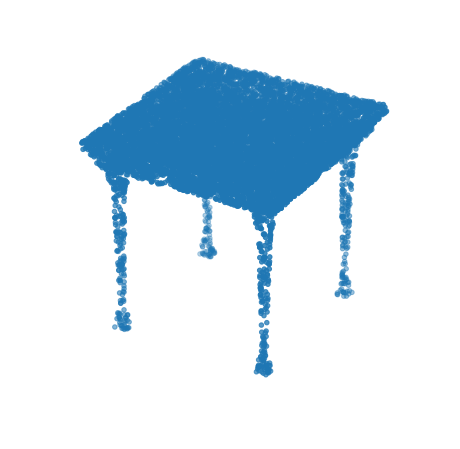

In [100]:
mesh = trimesh.load(os.path.join(DATA_DIR, 'table/train/table_0028.off'))
points = mesh.sample(10096)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()


device=torch.device("cuda:0")
mesh = IO().load_mesh(os.path.join(DATA_DIR, 'table/train/table_0028.off'), device=device)

verts=torch.Tensor(points)
rgb=torch.randn(verts.shape)


point_cloud = Pointclouds(points=[verts], features=[rgb])

***HOW GENERATE MULTIPLE VIEWS FROM THE POINTCLOUD***

***show the siluette from different perspective***

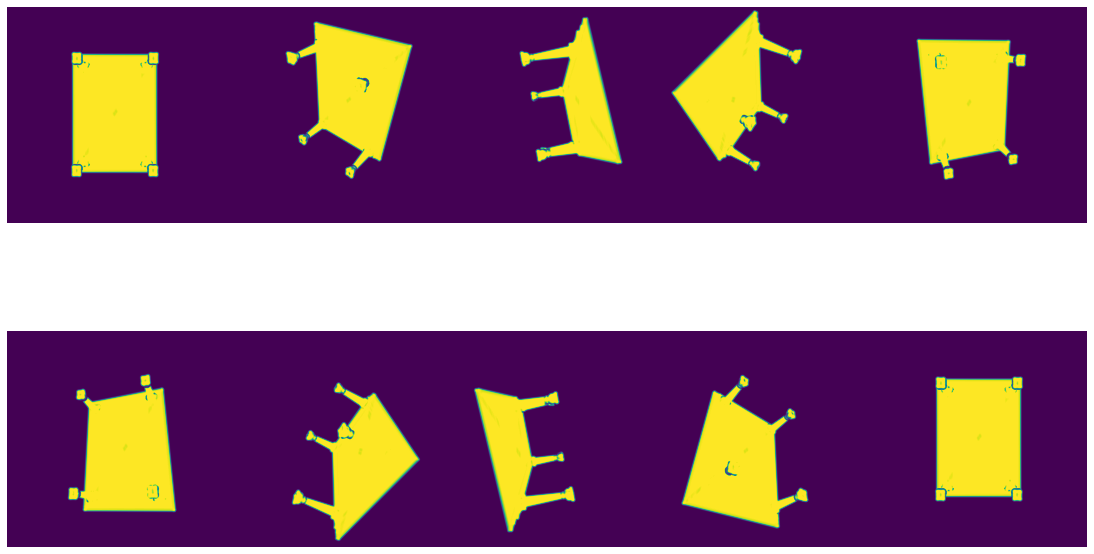

torch.Size([10, 512, 512, 4])


In [118]:
num_views = 10

# make the scene centered in offset
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

# different projection (elev, azim)
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# control the light location
lights = PointLights(device=device)

# control the camera perspective pose
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], T=T[None, 1, ...]) 

sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=512, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)
# render the mesh
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)
meshes = mesh.extend(num_views)

silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

image_grid(silhouette_images.cpu().numpy(), rows=2, cols=5, rgb=False)
plt.show()

print(silhouette_images.shape)

**render the images**

In [113]:
# Setup cuda
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# that function render the pointcloud
def get_points_renderer(
    image_size=512, device=None, radius=0.01, background_color=(1, 1, 1)
):
    """ source: https://github.com/learning3d/assignment1/blob/master/starter/utils.py
    Returns a Pytorch3D renderer for point clouds.
    Args:
        image_size (int): The rendered image size.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
        radius (float): The radius of the rendered point in NDC.
        background_color (tuple): The background color of the rendered image.
    
    Returns:
        PointsRenderer.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = PointsRasterizationSettings(image_size=image_size, radius=radius,)
    renderer = PointsRenderer(
        rasterizer=PointsRasterizer(raster_settings=raster_settings),
        compositor=AlphaCompositor(background_color=background_color),
    )
    return renderer

def get_mesh_renderer(image_size=512, lights=None, device=None):
    """
    Returns a Pytorch3D Mesh Renderer.
    Args:
        image_size (int): The rendered image size.
        lights: A default Pytorch3D lights object.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = RasterizationSettings(
        image_size=image_size, blur_radius=0.0, faces_per_pixel=1,
    )
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
        shader=HardPhongShader(device=device, lights=lights),
    )
    return renderer

***example of how generate multiple views from modelnet40 meshes***

In [123]:
device=torch.device("cuda:0")
mesh = IO().load_mesh(os.path.join(DATA_DIR, 'table/train/table_0028.off'), device=device)

In [175]:
num_img=10

# make the scene centered in offset
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

# add texture rgb to the object
verts_rgb = torch.zeros([1, mesh.verts_list()[0].shape[0], 3], device=device)

# try to add colors but does not works
#import igl
#v,f=igl.read_triangle_mesh(os.path.join(DATA_DIR, 'table/train/table_0028.off'))
#vs=np.array([0])
#vt=np.arange(len(v))
#d=igl.exact_geodesic(v,f,vs,vt)
#c=np.sin(d)
#verts_rgb=torch.stack((torch.Tensor(c)*10,torch.Tensor(c)*10,torch.Tensor(c)*10), dim = 1).to(device)
#verts_rgb=verts_rgb[None,:]

mesh.textures = TexturesVertex(verts_features=verts_rgb) 

renders = []
angles = np.linspace(0,360,num_img)
for i, angle in enumerate(tqdm(angles)):
    R, T = pytorch3d.renderer.look_at_view_transform(dist=5.0, elev=2, azim=angle)
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
    renderer=get_mesh_renderer(device=device)
    rend = renderer(mesh, cameras=cameras)
    rend = rend.cpu().numpy()
    renders.append(rend[0])

100%|██████████| 10/10 [00:00<00:00, 36.52it/s]


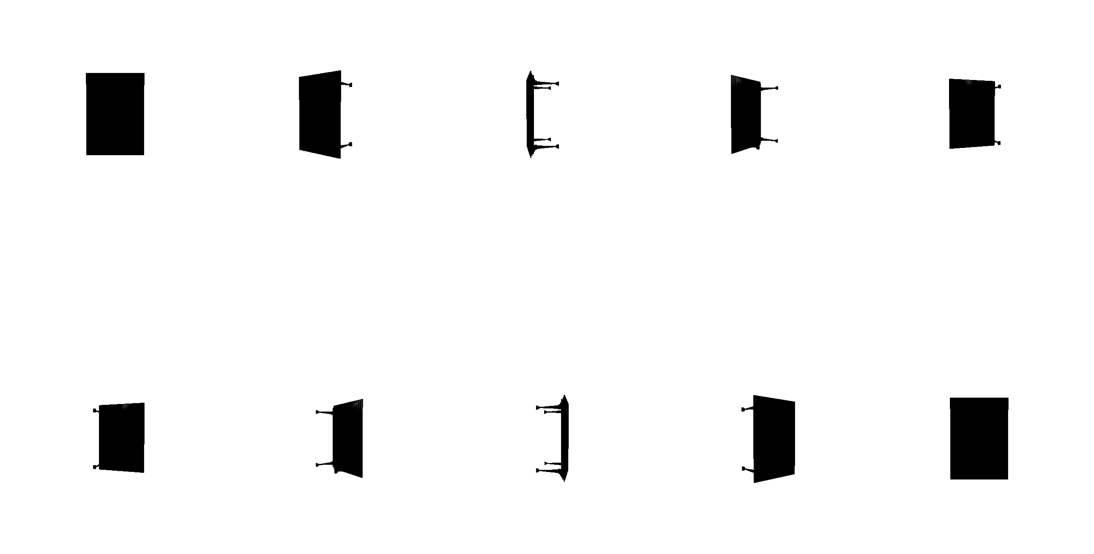

In [176]:
image_grid(torch.Tensor(renders).numpy(), rows=2, cols=5, rgb=True)
plt.show()

In [139]:
images = []
for i, r in enumerate(renders):
    image = Image.fromarray((r * 255).astype(np.uint8))
    draw = ImageDraw.Draw(image)
    images.append(np.array(image))

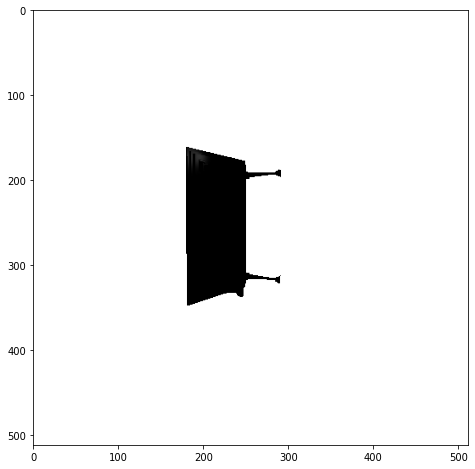

In [141]:
plt.figure(figsize=(8,8))

plt.imshow(images[3])

In [236]:
# image generator
def image_gen(renders):
  images = []
  for i, r in enumerate(renders):
      image = Image.fromarray((r * 255).astype(np.uint8))
      draw = ImageDraw.Draw(image)
      images.append(np.array(image))
  return images

# render generator
def render_gen(currentfolder,device=device):
  # setup
  device=torch.device("cuda:0")
  mesh = IO().load_mesh(currentfolder, device=device)
  # number of views
  num_img=10

  # make the scene centered in offset
  verts = mesh.verts_packed()
  N = verts.shape[0]
  center = verts.mean(0)
  scale = max((verts - center).abs().max(0)[0])
  mesh.offset_verts_(center)
  mesh.scale_verts_((1.0 / float(scale)));

  # add texture rgb to the object
  c=torch.abs(torch.sin(torch.stack([torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0])],dim=1))).to(device)
  c=c[None,:] # with this trick we add a texture to the mesh even if there is no texture
  verts_rgb = torch.zeros([1, mesh.verts_list()[0].shape[0], 3], device=device)+c
  mesh.textures = TexturesVertex(verts_features=verts_rgb) 

  renders = []
  angles = np.linspace(0,360,num_img)
  for i, angle in enumerate(tqdm(angles)):
      R, T = pytorch3d.renderer.look_at_view_transform(dist=4.0, elev=2, azim=angle)
      cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
      renderer=get_mesh_renderer(device=device)
      rend = renderer(mesh, cameras=cameras)
      rend = rend.cpu().numpy()
      renders.append(rend[0])

  return renders

# parse the entire dataset
def parse_dataset(num_points=4096):

    points = []
    labels = []
    images_obj = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        
        print("processing class: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]
        train_files = glob.glob(os.path.join(folder, "train/*0001.off"))
        test_files = glob.glob(os.path.join(folder, "test/*0001.off"))
        
        files = sorted(test_files+train_files)
        for f in files:
            points.append(trimesh.load(f).sample(num_points))
            labels.append(i)
            images_obj.append(image_gen(render_gen(f)))

        

    return (
        np.array(points),
        np.array(labels),
        np.array(images_obj),
        class_map
        )

In [237]:
NUM_POINTS = 4096
NUM_CLASSES = 10

points, labels, images_obj, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: bathtub


100%|██████████| 10/10 [00:00<00:00, 36.21it/s]


processing class: sofa


100%|██████████| 10/10 [00:00<00:00, 43.90it/s]


processing class: desk


100%|██████████| 10/10 [00:00<00:00, 54.58it/s]


processing class: toilet


100%|██████████| 10/10 [00:00<00:00, 56.22it/s]


processing class: dresser


100%|██████████| 10/10 [00:00<00:00, 57.97it/s]


processing class: chair


100%|██████████| 10/10 [00:00<00:00, 56.89it/s]


processing class: monitor


100%|██████████| 10/10 [00:00<00:00, 59.08it/s]


processing class: bed


100%|██████████| 10/10 [00:00<00:00, 57.64it/s]


processing class: night_stand


100%|██████████| 10/10 [00:00<00:00, 21.84it/s]


processing class: table


100%|██████████| 10/10 [00:00<00:00, 55.20it/s]


{0: 'bathtub', 1: 'sofa', 2: 'desk', 3: 'toilet', 4: 'dresser', 5: 'chair', 6: 'monitor', 7: 'bed', 8: 'night_stand', 9: 'table'}


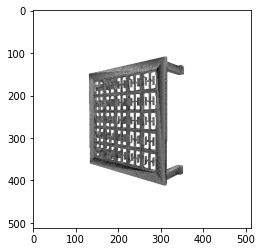

In [254]:
plt.imshow(images_obj[9][1])
print(CLASS_MAP)

In [248]:
# save the files
torch.save(points, 'points.pt')
torch.save(labels, 'labels.pt')
torch.save(images_obj, 'images_obj.pt')
torch.save(CLASS_MAP, 'CLASS_MAP.pt')


In [249]:
# download the files
files.download('points.pt') 
files.download('labels.pt') 
files.download('images_obj.pt') 
files.download('CLASS_MAP.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [278]:
verts, faces, _ = load_obj("airboat.obj")
mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)

In [279]:
c=torch.abs(torch.sin(torch.stack([torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0])],dim=1))).to(device)
c=c[None,:] # with this trick we add a texture to the mesh even if there is no texture
verts_rgb = torch.zeros([1, mesh.verts_list()[0].shape[0], 3], device=device)+c
mesh.textures = TexturesVertex(verts_features=verts_rgb) 

In [287]:
num_img=4
num_img=10

# make the scene centered in offset
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));


renders = []
angles = np.linspace(0,360,num_img)
for i, angle in enumerate(tqdm(angles)):
    R, T = pytorch3d.renderer.look_at_view_transform(dist=3.0, elev=2, azim=angle)
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
    renderer=get_mesh_renderer(device=device)
    rend = renderer(mesh, cameras=cameras)
    rend = rend.cpu().numpy()
    renders.append(rend)

100%|██████████| 10/10 [00:00<00:00, 35.20it/s]


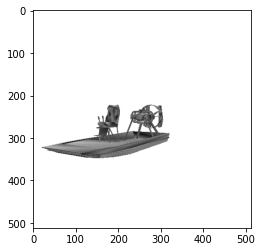

In [286]:
im=renders[3]
plt.imshow(im[0,..., :3])

***store the images***